In [2]:


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob as globlib
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [ ]:
os.chdir("./..")
os.getcwd()

In [3]:
import glob
# ============================
# Sub-patch generation
# ============================
def generate_sub_patches(coords, colors, normals, strength, labels, max_points=20000):
    N = coords.shape[0]
    sub_patches = []

    if N <= max_points:
        sub_patches.append({
            "coords": coords,
            "colors": colors,
            "normals": normals,
            "strength": strength,
            "labels": labels
        })
    else:
        n_sub = (N + max_points - 1) // max_points
        for _ in range(n_sub):
            idx = np.random.choice(N, max_points, replace=False)
            sub_patches.append({
                "coords": coords[idx],
                "colors": colors[idx],
                "normals": normals[idx],
                "strength": strength[idx],
                "labels": labels[idx]
            })
    return sub_patches


# ============================
# Dataset class
# ============================
class RoomPatchDataset(Dataset):
    def __init__(self, root_dir, use_norm=True, max_points=20000):
        self.folders = sorted([d for d in glob.glob(os.path.join(root_dir, "*")) if os.path.isdir(d)])
        self.use_norm = use_norm
        self.max_points = max_points
        self.sub_patches = []

        for folder in self.folders:
            coord_file = "coord_norm.npy" if use_norm else "coord.npy"
            coords = np.load(os.path.join(folder, coord_file)).astype(np.float32)
            colors = np.load(os.path.join(folder, "color.npy")).astype(np.float32)
            normals = np.load(os.path.join(folder, "normal.npy")).astype(np.float32)
            strength = np.load(os.path.join(folder, "strength.npy")).astype(np.float32).reshape(-1, 1)
            labels = np.load(os.path.join(folder, "segment.npy")).astype(np.int64)

            if coords.shape[0] == 0:
                print(f"Empty patch in folder {folder}, skipping...")
                continue

            # Normalize colors if needed
            if colors.max() > 1.5:
                colors = colors / 255.0

            # Normalize strength to [-1, 1]
            s_min, s_max = strength.min(), strength.max()
            if s_max != s_min:
                strength = 2 * (strength - s_min) / (s_max - s_min) - 1
            else:
                strength = np.zeros_like(strength)

            # Ensure shapes [N,3] for coords and normals
            if coords.shape[1] != 3:
                coords = coords.T
            if normals.shape[1] != 3:
                normals = normals.T

            patches = generate_sub_patches(coords, colors, normals, strength, labels, self.max_points)
            self.sub_patches.extend(patches)

    def __len__(self):
        return len(self.sub_patches)

    def __getitem__(self, idx):
        patch = self.sub_patches[idx]
        coords = patch["coords"]
        colors = patch["colors"]
        normals = patch["normals"]
        strength = patch["strength"]
        labels = patch["labels"]

        # Concatenate features: xyz + rgb + normals + strength
        feats = np.concatenate([coords, colors, normals, strength], axis=1).astype(np.float32)

        return {
            "xyz": torch.from_numpy(coords),          # [N,3]
            "feats": torch.from_numpy(feats),         # [N,10]
            "labels": torch.from_numpy(labels)        # [N]
        }


# ============================
# Quick test
# ============================
if __name__ == "__main__":
    dataset_path = "/dataset/train/chunks"
    ds = RoomPatchDataset(dataset_path, use_norm=True, max_points=20000)
    loader = DataLoader(ds, batch_size=2, shuffle=True)

    for batch in loader:
        print("XYZ shape:", batch["xyz"].shape)
        print("Feats shape:", batch["feats"].shape)
        print("Labels shape:", batch["labels"].shape)
        break


XYZ shape: torch.Size([2, 20000, 3])
Feats shape: torch.Size([2, 20000, 10])
Labels shape: torch.Size([2, 20000])


In [6]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ===========================
# Dataset class with normals + strength
# ===========================

# ===========================
# RandLA-Net model (10-channel input)
# ===========================
class RandlaNet(nn.Module):
    def __init__(self, d_out, n_layers, n_classes):
        super(RandlaNet, self).__init__()
        self.n_classes = n_classes
        dilate_block_in = 8

        # First FC layer: now 10 input features
        self.fc1 = nn.Linear(10, dilate_block_in)
        self.bn1 = nn.BatchNorm1d(dilate_block_in, eps=1e-6, momentum=0.01)

        # Encoders
        self.f_encoders = nn.ModuleList()
        decoder_in_list = [d_out[0]*2]
        for i in range(n_layers):
            self.f_encoders.append(DilatedResidualBlock(dilate_block_in, d_out[i]))
            dilate_block_in = d_out[i]*2
            decoder_in_list.append(dilate_block_in)

        # Bottleneck conv
        self.conv2 = nn.Conv2d(dilate_block_in, dilate_block_in, kernel_size=[1,1], stride=[1,1])
        self.bn2 = nn.BatchNorm2d(dilate_block_in, eps=1e-6, momentum=0.01)

        # Decoders
        self.f_decoders = nn.ModuleList()
        for i in range(n_layers):
            self.f_decoders.append(FeatureDecoder(decoder_in_list[-i-1] + decoder_in_list[-i-2],
                                                  decoder_in_list[-i-2]))

        # Output layers
        self.conv3 = nn.Conv2d(decoder_in_list[0], 64, kernel_size=[1,1], stride=[1,1])
        self.bn3 = nn.BatchNorm2d(64, eps=1e-6, momentum=0.01)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=[1,1], stride=[1,1])
        self.bn4 = nn.BatchNorm2d(32, eps=1e-6, momentum=0.01)
        self.drop4 = nn.Dropout2d(p=0.5)
        self.conv5 = nn.Conv2d(32, self.n_classes, kernel_size=[1,1], stride=[1,1])

    def forward(self, inputs):
        x = inputs['features']                 # [B, N, 10]
        x = self.fc1(x)                        # [B, N, 8]
        x = x.permute(0, 2, 1).contiguous()    # [B, 8, N]
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = x[:, :, :, None]                   # [B, 8, N, 1]

        encoded_list = []
        for i, encoder in enumerate(self.f_encoders):
            x = encoder(x, inputs['xyz'][i], inputs['neigh_idx'][i])
            if i == 0:
                encoded_list.append(x.clone())
            x = random_sample(x, inputs['sub_idx'][i])
            encoded_list.append(x.clone())

        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)

        for i, decoder in enumerate(self.f_decoders):
            x = decoder(x, encoded_list[-i-2], inputs['interp_idx'][-i-1])

        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = self.drop4(x)
        x = self.conv5(x)  # [B, C, N, 1]

        x = x.squeeze(-1).permute(0, 2, 1).reshape([-1, self.n_classes]).contiguous()  # [(B*N), C]
        return x

# ==========
# Remaining supporting classes/functions
# ==========
class FeatureDecoder(nn.Module):
    def __init__(self, f_in, f_out):
        super(FeatureDecoder, self).__init__()
        self.trconv1 = nn.ConvTranspose2d(f_in, f_out, kernel_size=[1, 1], stride=[1, 1])
        self.bn1 = nn.BatchNorm2d(f_out, eps=1e-6, momentum=0.01)

    def forward(self, feature, encoded_feature, interp_idx):
        f_interp_i = nearest_interpolation(feature, interp_idx)
        f_decoded = self.trconv1(torch.cat([encoded_feature, f_interp_i], dim=1))
        f_decoded = self.bn1(f_decoded)
        return f_decoded

class DilatedResidualBlock(nn.Module):
    def __init__(self, f_in, d_out):
        super(DilatedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(f_in, d_out//2, kernel_size=[1,1], stride=[1,1])
        self.bn1 = nn.BatchNorm2d(d_out//2, eps=1e-6, momentum=0.01)
        self.bb = BuildingBlock(d_out)
        self.conv2 = nn.Conv2d(d_out, d_out*2, kernel_size=[1,1], stride=[1,1])
        self.bn2 = nn.BatchNorm2d(d_out*2, eps=1e-6, momentum=0.01)
        self.shortcut = nn.Conv2d(f_in, d_out*2, kernel_size=[1,1], stride=[1,1])
        self.bn_shortcut = nn.BatchNorm2d(d_out*2, eps=1e-6, momentum=0.01)

    def forward(self, feature, xyz, neigh_idx):
        f_pc = F.leaky_relu(self.bn1(self.conv1(feature)), negative_slope=0.2)
        f_pc = self.bb(xyz, f_pc, neigh_idx)
        f_pc = self.bn2(self.conv2(f_pc))
        shortcut = self.bn_shortcut(self.shortcut(feature))
        return F.leaky_relu(f_pc + shortcut)

class BuildingBlock(nn.Module):
    def __init__(self, d_out):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(10, d_out//2, kernel_size=[1,1], stride=[1,1])
        self.bn1 = nn.BatchNorm2d(d_out//2, eps=1e-6, momentum=0.01)
        self.attpool1 = AttentivePooling(2*(d_out//2), d_out//2)
        self.conv2 = nn.Conv2d(d_out//2, d_out//2, kernel_size=[1,1], stride=[1,1])
        self.bn2 = nn.BatchNorm2d(d_out//2, eps=1e-6, momentum=0.01)
        self.attpool2 = AttentivePooling(2*(d_out//2), d_out)

    def forward(self, xyz, feature, neigh_idx):
        f_xyz = relative_pos_encoding(xyz, neigh_idx)
        f_xyz = F.leaky_relu(self.bn1(self.conv1(f_xyz)), negative_slope=0.2)
        feature = torch.squeeze(feature, dim=-1).permute(0,2,1).contiguous()
        f_neighbours = gather_neighbour(feature, neigh_idx)
        f_concat = torch.cat([f_neighbours, f_xyz], dim=1)
        f_pc_agg = self.attpool1(f_concat)

        f_xyz = F.leaky_relu(self.bn2(self.conv2(f_xyz)), negative_slope=0.2)
        f_pc_agg = torch.squeeze(f_pc_agg, dim=-1).permute(0,2,1).contiguous()
        f_neighbours = gather_neighbour(f_pc_agg, neigh_idx)
        f_concat = torch.cat([f_neighbours, f_xyz], dim=1)
        f_pc_agg = self.attpool2(f_concat)
        return f_pc_agg

class AttentivePooling(nn.Module):
    def __init__(self, n_feature, d_out):
        super(AttentivePooling, self).__init__()
        self.fc1 = nn.Linear(n_feature, n_feature, bias=False)
        self.conv1 = nn.Conv2d(n_feature, d_out, kernel_size=[1,1], stride=[1,1])
        self.bn1 = nn.BatchNorm2d(d_out, eps=1e-6, momentum=0.01)

    def forward(self, x):
        B, C, N, K = x.shape
        x_perm = x.permute(0,2,3,1).contiguous()  # [B,N,K,C]
        att_activation = self.fc1(x_perm)
        att_score = F.softmax(att_activation, dim=2)
        x_weighted = x_perm * att_score
        x_agg = torch.sum(x_weighted, dim=2)  # [B,N,C]
        x_agg = x_agg.permute(0,2,1).unsqueeze(-1).contiguous()
        x = F.leaky_relu(self.bn1(self.conv1(x_agg)), negative_slope=0.2)
        return x

# ==============
# Utility functions
# ==============
def relative_pos_encoding(xyz, neighbor_idx):
    neighbor_xyz = gather_neighbour(xyz, neighbor_idx)
    xyz0 = xyz[:, :, None, :].permute(0,3,1,2).contiguous()
    repeated_xyz = xyz0.repeat(1,1,1,neighbor_idx.shape[-1])
    relative_xyz = repeated_xyz - neighbor_xyz
    relative_dist = torch.sqrt(torch.sum(relative_xyz**2, dim=1, keepdim=True) + 1e-9)
    relative_feature = torch.cat([relative_dist, relative_xyz, repeated_xyz, neighbor_xyz], dim=1)
    return relative_feature

def gather_neighbour(point_features, neighbor_idx):
    B,N,C = point_features.shape
    K = neighbor_idx.shape[-1]
    index_input = neighbor_idx.reshape(B,-1)
    features = batch_gather(point_features, index_input)
    features = features.reshape(B,N,K,C)
    return features.permute(0,3,1,2).contiguous()

def random_sample(feature, pool_idx):
    feature = torch.squeeze(feature, dim=3)  # [B,d,N]
    B,d,N = feature.shape
    M = pool_idx.shape[-1]
    feature = feature.permute(0,2,1).contiguous()  # [B,N,d]
    pool_idx = pool_idx.reshape(B,-1)
    pool_features = batch_gather(feature, pool_idx)
    pool_features = pool_features.reshape(B,-1,M,d)
    pool_features = torch.max(pool_features, dim=2, keepdim=True)[0]
    return pool_features.permute(0,3,1,2).contiguous()

def nearest_interpolation(feature, interp_idx):
    feature = torch.squeeze(feature, dim=3)
    B,d,Nc = feature.shape
    Nf = interp_idx.shape[1]
    idx = interp_idx.reshape(B,Nf)
    feature = feature.permute(0,2,1).contiguous()
    interp_features = batch_gather(feature, idx)
    return interp_features.permute(0,2,1)[:,:,:,None].contiguous()

def batch_gather(tensor, indices):
    shape = list(tensor.shape)
    device = tensor.device
    flat_first = tensor.reshape([shape[0]*shape[1]] + shape[2:])
    offset = (torch.arange(shape[0], device=device) * shape[1]).reshape([shape[0]] + [1]*(indices.ndim-1))
    return flat_first[indices.long()+offset]




In [7]:
import torch
from typing import List, Tuple

# ============================
# Vectorized GPU-friendly Farthest Point Sampling (Batch Support)
# ============================
def farthest_point_sample_batch(xyz: torch.Tensor, npoint: int) -> torch.Tensor:
    """
    Batch GPU-friendly FPS.
    xyz: [B, N, 3]
    Returns: [B, npoint] indices
    """
    B, N, _ = xyz.shape
    device = xyz.device
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), device=device)
    batch_indices = torch.arange(B, device=device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid_xyz = xyz[batch_indices, farthest, :].unsqueeze(1)  # [B,1,3]
        dist = torch.sum((xyz - centroid_xyz) ** 2, dim=2)
        distance = torch.minimum(distance, dist)
        farthest = torch.argmax(distance, dim=1)
    return centroids

# ============================
# Vectorized KNN (GPU)
# ============================
def knn_gather(xyz_src: torch.Tensor, xyz_query: torch.Tensor, k: int) -> torch.Tensor:
    """
    xyz_src: [B, N, 3], xyz_query: [B, M, 3]
    Returns: indices of k nearest neighbors [B, M, k]
    """
    dists = torch.cdist(xyz_query, xyz_src, p=2)  # [B, M, N]
    knn_idx = torch.topk(dists, k, largest=False).indices  # [B, M, k]
    return knn_idx

# ============================
# GPU-friendly Pyramid Builder (Batch + Fully GPU)
# ============================
@torch.no_grad()

def build_pyramid_gpu_batch(
    xyz_b: torch.Tensor,
    k: int,
    n_layers: int,
    ratios: List[int],
    pool_size: int = 16
) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
    """
    GPU pyramid builder for RandLA-Net
    Works for any batch size B>=1
    Returns lists of tensors per layer
    """
    B, N, _ = xyz_b.shape
    device = xyz_b.device

    xyz_list, neigh_list, sub_list, interp_list = [], [], [], []

    xyz_i = xyz_b.clone()  # [B, N, 3]

    for level in range(n_layers):
        Ni = xyz_i.shape[1]

        # neighbors
        neigh_idx = knn_gather(xyz_i, xyz_i, k + 1)[:, :, 1:]  # [B, Ni, k]
        neigh_list.append(neigh_idx)

        # store xyz
        xyz_list.append(xyz_i)

        # subsample
        ratio = ratios[level]
        Ni_next = max(1, Ni // ratio)
        if Ni_next >= Ni:
            J = torch.arange(Ni, device=device).unsqueeze(0).repeat(B, 1)
        else:
            J = farthest_point_sample_batch(xyz_i, Ni_next)

        batch_indices = torch.arange(B, device=device).unsqueeze(1)
        xyz_next = xyz_i[batch_indices, J, :]

        # sub_idx
        sub_idx = knn_gather(xyz_i, xyz_next, pool_size)
        sub_list.append(sub_idx)

        # interp_idx
        interp_idx = knn_gather(xyz_next, xyz_i, 1)
        interp_list.append(interp_idx)

        xyz_i = xyz_next

    return xyz_list, neigh_list, sub_list, interp_list



In [11]:
import time
from sklearn.metrics import f1_score

# Compute class weights
# -------------------------
def compute_class_weights(root_dir, n_classes):
    # Get all subfolders (areas)
    area_folders = sorted([d for d in glob.glob(os.path.join(root_dir, "*")) if os.path.isdir(d)])
    if len(area_folders) == 0:
        raise ValueError(f"No area folders found in {root_dir}")

    all_labels = []
    for area in area_folders:
        segment_file = os.path.join(area, "segment.npy")
        if os.path.exists(segment_file):
            labels = np.load(segment_file).flatten()
            all_labels.append(labels)
        else:
            print(f"Warning: {segment_file} not found.")

    if len(all_labels) == 0:
        raise ValueError("No segment.npy files found. Cannot compute class weights.")

    all_labels = np.concatenate(all_labels)
    counts = np.bincount(all_labels, minlength=n_classes)
    class_weights = 1.0 / (counts + 1e-6)
    class_weights = class_weights / class_weights.sum() * n_classes
    print("Class weights:", class_weights)

    return torch.tensor(class_weights, dtype=torch.float32)


# -------------------------
# Main training function
# -------------------------
def main():
    # -------------------------
    # Settings
    # -------------------------
    train_root = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/dataset/train/chunks"
    n_classes  = 14
    n_layers   = 4
    ratios     = [4] * n_layers
    k_neighbors = 64
    pool_size   = 32
    epochs      = 200
    lr          = 1e-3
    batch_size  = 2
    save_model_dir = "/saved_models_randlanet"
    os.makedirs(save_model_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # -------------------------
    # Dataset & DataLoader
    # -------------------------
    train_ds = RoomPatchDataset(train_root)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

    # -------------------------
    # Model, optimizer, loss
    # -------------------------
    d_out = [16, 64, 128, 256]
    model = RandlaNet(d_out=d_out, n_layers=n_layers, n_classes=n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    class_weights = compute_class_weights(train_root, n_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # -------------------------
    # Training loop
    # -------------------------
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, n_points = 0.0, 0
        all_preds, all_labels = [], []

        start_time = time.time()

        # Adjust learning rate every 30 epochs
        if epoch % 20 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.9
            print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']} at epoch {epoch}")


        for batch in train_loader:
            xyz    = batch["xyz"].to(device)
            feats  = batch["feats"].to(device)
            labels = batch["labels"].to(device).view(-1)

            xyz_list, neigh_list, sub_list, interp_list = build_pyramid_gpu_batch(
                xyz_b=xyz,
                k=k_neighbors,
                n_layers=n_layers,
                ratios=ratios,
                pool_size=pool_size
            )

            inputs = {
                "features": feats,
                "xyz": xyz_list,
                "neigh_idx": neigh_list,
                "sub_idx": sub_list,
                "interp_idx": interp_list
            }

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.numel()
            n_points += labels.numel()

            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        # -------------------------
        # Epoch metrics
        # -------------------------
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        epoch_loss = running_loss / max(1, n_points)
        epoch_acc = (all_preds == all_labels).sum() / len(all_labels)
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")
        elapsed = time.time() - start_time

        print(f"Epoch {epoch:03d}/{epochs}, Loss: {epoch_loss:.4f}, "
              f"Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}, Time: {elapsed:.2f}s")

        # Save model
        save_path = os.path.join(save_model_dir, f"epoch_{epoch:03d}_randlanet.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Saved: {save_path}\n")


if __name__ == "__main__":
    main()


Device: cuda
Class weights: [0.01694514 0.06488931 0.11854593 0.15575704 0.01486359 0.02093645
 0.1366988  8.26623022 0.10551895 0.21496573 3.62682647 0.82624401
 0.24202165 0.18955672]
Epoch 001/200, Loss: 1.8143, Acc: 0.5481, F1: 0.5569, LR: 0.001000, Time: 452.38s
Saved: /home/dikshantpatel/Dikshant/Semantic_Segmentation/saved_models_randlanet/epoch_001_randlanet.pth

Epoch 002/200, Loss: 1.1749, Acc: 0.7350, F1: 0.7532, LR: 0.001000, Time: 445.41s
Saved: /home/dikshantpatel/Dikshant/Semantic_Segmentation/saved_models_randlanet/epoch_002_randlanet.pth

Epoch 003/200, Loss: 0.8642, Acc: 0.7923, F1: 0.8085, LR: 0.001000, Time: 445.00s
Saved: /home/dikshantpatel/Dikshant/Semantic_Segmentation/saved_models_randlanet/epoch_003_randlanet.pth

Epoch 004/200, Loss: 0.6943, Acc: 0.8326, F1: 0.8454, LR: 0.001000, Time: 446.17s
Saved: /home/dikshantpatel/Dikshant/Semantic_Segmentation/saved_models_randlanet/epoch_004_randlanet.pth

Epoch 005/200, Loss: 0.5698, Acc: 0.8530, F1: 0.8653, LR: 0.00

In [ ]:


# ============================
# Dataset & Sub-patch logic
# ============================
def generate_sub_patches(coords, colors, normals, strength, labels, max_points=20000):
    N = coords.shape[0]
    sub_patches = []

    if N <= max_points:
        sub_patches.append({
            "coords": coords,
            "colors": colors,
            "normals": normals,
            "strength": strength,
            "labels": labels
        })
    else:
        n_sub = (N + max_points - 1) // max_points
        for _ in range(n_sub):
            idx = np.random.choice(N, max_points, replace=False)
            sub_patches.append({
                "coords": coords[idx],
                "colors": colors[idx],
                "normals": normals[idx],
                "strength": strength[idx],
                "labels": labels[idx]
            })
    return sub_patches


class RoomPatchDataset(Dataset):
    def __init__(self, root_dir_list, max_points=20000):
        if isinstance(root_dir_list, str):
            root_dir_list = [root_dir_list]
        self.max_points = max_points
        self.sub_patches = []

        all_folders = []
        for root_dir in root_dir_list:
            subfolders = sorted([d for d in globlib.glob(os.path.join(root_dir, "*")) if os.path.isdir(d)])
            all_folders.extend(subfolders)
        if not all_folders:
            all_folders = root_dir_list

        for folder in all_folders:
            try:
                coords = np.load(os.path.join(folder, "coord_norm.npy")).astype(np.float32)
                colors = np.load(os.path.join(folder, "color.npy")).astype(np.float32)
                normals = np.load(os.path.join(folder, "normal.npy")).astype(np.float32)
                strength = np.load(os.path.join(folder, "strength.npy")).astype(np.float32).reshape(-1, 1)
                labels = np.load(os.path.join(folder, "segment.npy")).astype(np.int64)
            except Exception as e:
                print(f"⚠️ Skipping folder {folder}: {e}")
                continue

            if coords.shape[0] == 0:
                continue

            if colors.max() > 1.5:
                colors = colors / 255.0

            s_min, s_max = strength.min(), strength.max()
            strength = 2 * (strength - s_min) / (s_max - s_min) - 1 if s_max != s_min else np.zeros_like(strength)

            if coords.shape[1] != 3:
                coords = coords.T
            if normals.shape[1] != 3:
                normals = normals.T

            patches = generate_sub_patches(coords, colors, normals, strength, labels, self.max_points)
            self.sub_patches.extend(patches)

        if len(self.sub_patches) == 0:
            raise ValueError("No valid sub-patches found!")

    def __len__(self):
        return len(self.sub_patches)

    def __getitem__(self, idx):
        patch = self.sub_patches[idx]
        feats = np.concatenate([patch["coords"], patch["colors"], patch["normals"], patch["strength"]], axis=1).astype(
            np.float32)
        return {
            "xyz": torch.from_numpy(patch["coords"]),
            "feats": torch.from_numpy(feats),
            "labels": torch.from_numpy(patch["labels"])
        }


Model Epoch: 200
✅ Human-readable merged predictions saved: ../randlanet_test_output/merged_test_results_epoch_200.csv
✅ Metrics table saved: ../randlanet_test_output/metrics_epoch_200.csv

📊 Summary Metrics:
   Mean Accuracy: 78.85%
   Mean F1 Score: 72.20%
   Mean IoU:      63.78%


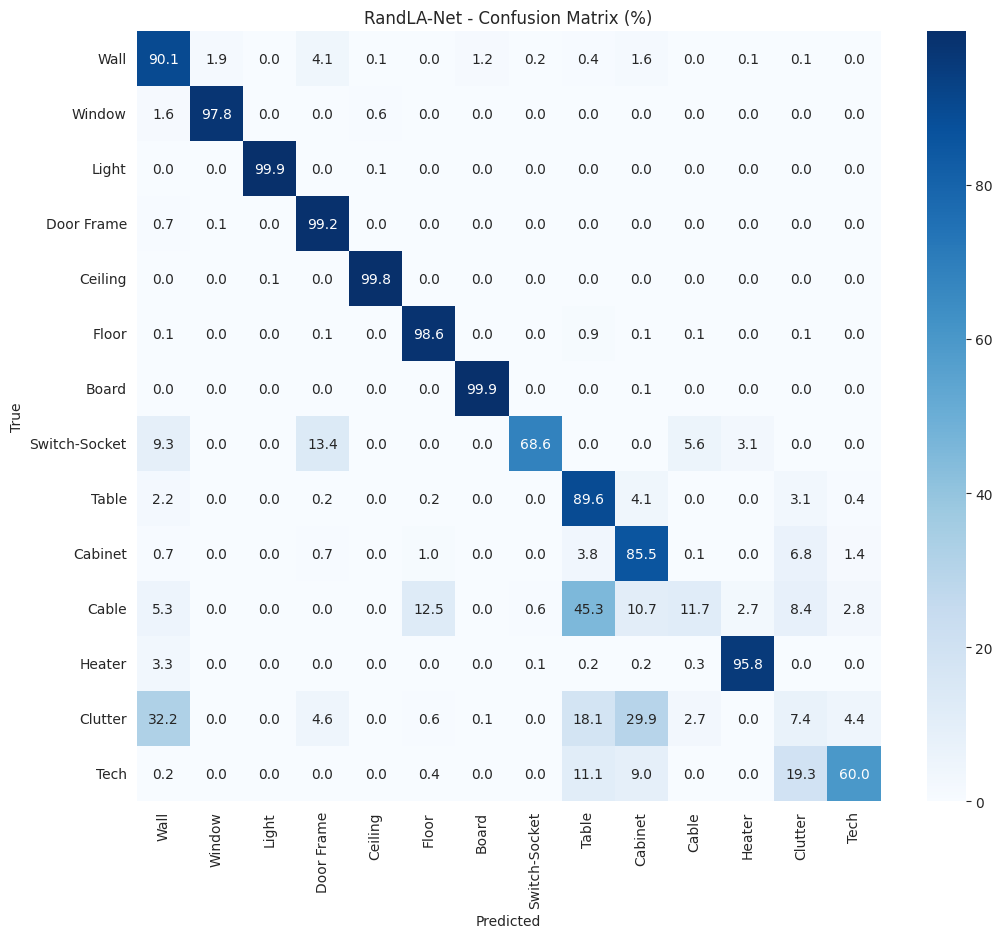

In [28]:
import os
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# IoU function
# ============================
def compute_iou_per_class(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    ious = []
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        denom = tp + fp + fn
        ious.append(tp / denom if denom != 0 else float("nan"))
    return ious, np.nanmean(ious)


# ============================
# Main test function
# ============================
def test_randlanet_human_readable(model_path, test_root, num_classes, batch_size=1,
                                  save_pred_dir="randlanet_test_output"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_pred_dir, exist_ok=True)

    # Class names
    class_names = [
        "Wall", "Window", "Light", "Door Frame", "Ceiling", "Floor",
        "Board", "Switch-Socket", "Table", "Cabinet", "Cable", "Heater",
        "Clutter", "Tech"
    ]

    # Extract epoch number
    epoch_match = re.search(r'epoch_(\d+)_', os.path.basename(model_path))
    epoch_number = int(epoch_match.group(1)) if epoch_match else -1
    print(f"Model Epoch: {epoch_number}")

    # Dataset
    test_ds = RoomPatchDataset(test_root, max_points=20000)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Load model (user should define RandlaNet & build_pyramid_gpu_batch)
    d_out = [16, 64, 128, 256]
    model = RandlaNet(d_out=d_out, n_layers=4, n_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds, all_labels, merged_all_points = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            xyz = batch["xyz"].to(device)
            feats = batch["feats"].to(device)
            labels = batch["labels"].to(device)
            labels_flat = labels.view(-1)

            # Build pyramid (must be implemented in your repo)
            xyz_list, neigh_list, sub_list, interp_list = build_pyramid_gpu_batch(
                xyz_b=xyz, k=16, n_layers=4, ratios=[4, 4, 4, 4], pool_size=16
            )

            inputs = {"features": feats, "xyz": xyz_list,
                      "neigh_idx": neigh_list, "sub_idx": sub_list, "interp_idx": interp_list}

            logits = model(inputs)
            preds = logits.argmax(dim=1).cpu().numpy()
            gt = labels_flat.cpu().numpy()

            # Save per-batch output (XYZ, RGB, Normals, GT, Pred, etc.)
            for i in range(xyz.shape[0]):
                coords_np = batch["xyz"][i].cpu().numpy()
                feats_np = batch["feats"][i].cpu().numpy()
                gt_np = batch["labels"][i].cpu().numpy()
                pred_np = preds.reshape(labels.shape)[i]

                feats_np = feats_np[:, 3:]
                rgb = (feats_np[:, 0:3] * 255).clip(0, 255).astype(np.int32)
                normals = feats_np[:, 3:6]
                strength = feats_np[:, 6:7]

                gt_names = np.array([class_names[x] for x in gt_np]).reshape(-1, 1)
                pred_names = np.array([class_names[x] for x in pred_np]).reshape(-1, 1)
                epoch_col = np.full((coords_np.shape[0], 1), epoch_number)

                full_output = np.hstack([
                    coords_np,      # 0-2
                    rgb,            # 3-5
                    normals,        # 6-8
                    strength,       # 9
                    gt_np.reshape(-1, 1),   # 10
                    pred_np.reshape(-1, 1), # 11
                    gt_names,       # 12
                    pred_names,     # 13
                    epoch_col       # 14
                ])
                merged_all_points.append(full_output)

            all_preds.append(preds)
            all_labels.append(gt)

    # ============================
    # Save merged predictions
    # ============================
    merged_all_points = np.vstack(merged_all_points)
    merged_file_path = os.path.join(save_pred_dir, f"merged_test_results_epoch_{epoch_number}.csv")
    df_merged = pd.DataFrame(
        merged_all_points,
        columns=["X", "Y", "Z", "R", "G", "B", "Nx", "Ny", "Nz", "Strength",
                 "GT_Label", "Pred_Label", "GT_Class", "Pred_Class", "Epoch"]
    )
    df_merged.to_csv(merged_file_path, index=False)
    print(f"✅ Human-readable merged predictions saved: {merged_file_path}")

    # ============================
    # Metrics Computation
    # ============================
    all_preds_flat = np.concatenate(all_preds)
    all_labels_flat = np.concatenate(all_labels)

    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels_flat, all_preds_flat, labels=np.arange(num_classes), zero_division=0
    )

    per_class_acc = []
    for i in range(num_classes):
        idx = all_labels_flat == i
        acc_i = np.sum(all_preds_flat[idx] == i) / np.sum(idx) if np.sum(idx) > 0 else np.nan
        per_class_acc.append(acc_i)

    ious, miou = compute_iou_per_class(all_labels_flat, all_preds_flat, num_classes)

    # Per-class metrics table
    table_data = []
    for i in range(num_classes):
        table_data.append([
            class_names[i],
            per_class_acc[i] * 100 if not np.isnan(per_class_acc[i]) else np.nan,
            f1[i] * 100 if not np.isnan(f1[i]) else np.nan,
            ious[i] * 100 if not np.isnan(ious[i]) else np.nan,
            support[i]
        ])

    df_metrics = pd.DataFrame(
        table_data,
        columns=["Class Name", "Accuracy (%)", "F1-score (%)", "IoU (%)", "Support (#points)"]
    )

    # Mean row
    mean_acc = np.nanmean(per_class_acc) * 100
    mean_f1 = np.nanmean(f1) * 100
    mean_iou = miou * 100
    df_metrics.loc["Mean"] = ["--", mean_acc, mean_f1, mean_iou, np.sum(support)]

    metrics_file = os.path.join(save_pred_dir, f"metrics_epoch_{epoch_number}.csv")
    df_metrics.to_csv(metrics_file, index=False)
    print(f"✅ Metrics table saved: {metrics_file}")

    # ============================
    # Print mean results
    # ============================
    print("\n📊 Summary Metrics:")
    print(f"   Mean Accuracy: {mean_acc:.2f}%")
    print(f"   Mean F1 Score: {mean_f1:.2f}%")
    print(f"   Mean IoU:      {mean_iou:.2f}%")

    # ============================
    # Confusion Matrix
    # ============================
    cm = confusion_matrix(all_labels_flat, all_preds_flat, labels=np.arange(num_classes))
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_percent, annot=True, fmt=".1f", cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"RandLA-Net - Confusion Matrix (%)")
    plt.show()

    return merged_file_path, metrics_file


# ============================
# Run test
# ============================
TEST_DIR = "/dataset1/test/chunks"
MODEL_PATH = "/output_randlanet/saved_models_randlanet/epoch_200_randlanet.pth"
NUM_CLASSES = 14
SAVE_PRED_DIR = "../randlanet_test_output"

merged_file, metrics_file = test_randlanet_human_readable(
    MODEL_PATH, TEST_DIR, NUM_CLASSES, batch_size=1, save_pred_dir=SAVE_PRED_DIR
)


In [12]:
import pandas as pd

# Replace with your CSV file path
csv_file = "/home/dikshantpatel/Dikshant/Semantic_Segmentation/randlanet_test_output/metrics_epoch_200.csv"
# Load CSV into a DataFrame
df = pd.read_csv(csv_file)
print(df)

       Class Name  Accuracy (%)  F1-score (%)    IoU (%)  Support (#points)
0            Wall     85.009553     90.043498  81.890109             877719
1          Window     97.932380     88.117120  78.758358             145046
2           Light     99.741164     99.153782  98.321765             129812
3      Door Frame     98.022993     44.939110  28.981589              22964
4         Ceiling     99.788071     99.763144  99.527407             996558
5           Floor     98.799434     98.769415  97.568749             495183
6           Board     99.981043     56.844913  39.708623              21100
7   Switch-Socket     64.823009     31.264450  18.528668               1356
8           Table     85.345928     74.887359  59.855949              99515
9         Cabinet     80.989730     68.861420  52.510421              99704
10          Cable     10.987894     14.232703   7.661576              10821
11         Heater     52.331347     67.696472  51.167549              21983
12        Cl